# import packages

In [1]:
%matplotlib inline

In [2]:
import os, glob
import wrf
from netCDF4 import Dataset
import pandas as pd
from sys import stdout
import numpy as np

In [3]:

import xarray, wrf
from pandas import to_datetime
from scipy.signal import welch
from scipy import fftpack
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [4]:
from IPython.display import Image


import matplotlib.dates as mdates

import pandas as pd

In [5]:
fs=16
plt.rc("font",size=fs)

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# define parameters

In [7]:
figPath = "/glade/u/home/doubrawa/figs/"

In [8]:
outPath = "/glade/scratch/doubrawa/post_processing/"

In [9]:
inPath = "/glade/scratch/doubrawa/gray_zone/mesoscale/wrf_again/"

### define a time

In [10]:
year     = 2015
month    = 3

In [72]:
days = [30]#,21,28,29,30]

### alocate space to store pblh

In [73]:
zi_dict = {}
zi_std = {}

In [74]:
# how wide of a square box should we consider when averaging zi in space? [km]
extent_of_interest_km = 15
# spatial resolution of domain output in x/y [km]
dx_km = 1.0
# which grid points does that correspond to?
extent_of_interest_npts = int(np.round(extent_of_interest_km/dx_km))

In [75]:
extent_of_interest_npts

15

In [76]:
# for each instant, read in the previously-patched LES fields and the gray zone wrfout fields

i = 0

for day in days:
    
    directory = os.path.join(inPath,"03{0}15".format(day))
    wrfouts = sorted(glob.glob(os.path.join(directory,"wrfout_d02*")))
    for wrfout in wrfouts:
        
        # open file
        wrfnc = Dataset(wrfout)
        
        # find out what time this file is for (utc)
        datetime_pandas = pd.Timestamp(wrf.getvar(wrfnc,"Times").data).tz_localize("UTC")
        
        if datetime_pandas.hour>=14:

            # print out what time it is
            stdout.write('\r{0}'.format(datetime_pandas))     

            # get zi for entire domain
            zi = wrf.getvar(wrfnc, "PBLH", timeidx=0)     

            if i==0:
                n_sn = getattr(wrfnc,"SOUTH-NORTH_PATCH_END_UNSTAG")
                n_we = getattr(wrfnc,"WEST-EAST_PATCH_END_UNSTAG")

                sn_start = int((n_sn-extent_of_interest_npts)/2)
                sn_end = int(sn_start+extent_of_interest_npts)

                we_start = int((n_we-extent_of_interest_npts)/2)
                we_end = int(we_start+extent_of_interest_npts)

            # since this is a noisy quantity, clip only to middle of domain where we will be analyzing anyway
            zi_subset = zi.isel(south_north=np.arange(sn_start,sn_end,1)).isel(west_east=np.arange(we_start,we_end,1))

            zi_dict[datetime_pandas] = np.median(zi_subset.data)
            zi_std[datetime_pandas] = np.std(zi_subset.data)

            i+=1

2015-03-30 23:50:00+00:00

In [77]:
series1 = pd.Series(zi_dict)
series2 = pd.Series(zi_std)

In [78]:
df = pd.concat([series1,series2],axis=1)
df.columns = ["median","std"]

### visualize what came out of this...

### save as csv

<ErrorbarContainer object of 3 artists>

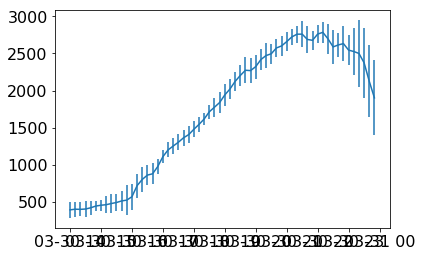

In [79]:
plt.figure()
plt.errorbar(df.index, df['median'].values, yerr=df['std'].values)

In [80]:
fout = "PBLH_SPATIAL_AVG_{0:.0f}km_by_{0:.0f}km_D02_March{1}.csv".format(extent_of_interest_km,day)
print(fout)

PBLH_SPATIAL_AVG_15km_by_15km_D02_March30.csv


In [81]:
df.to_csv(os.path.join(outPath,fout))